## Introduction Fun with Flags

This paper gives Principal Component Analysis (PCA) a fresh upgrade using flag manifolds, making it better at handling noisy and messy data. The authors introduce "flagification," a framework that organizes PCA into a versatile method for both clean and challenging datasets. Using flag manifolds, they create efficient algorithms capable of handling everything from noisy images to curved spaces.

Table 3 compares traditional PCA methods (like L1-RPCA) with the new "flagified" ones (fRPCA, etc.), showing that the flagified methods perform as well or better while often being faster; especially for robust PCA tasks. In short, this paper makes PCA more powerful, flexible, and reliable, with results that prove it works in practice.

## Step 1 - setting up the env


In [16]:
!conda env create -f environment.yml
!conda activate fun-flags

Retrieving notices: ...working... done



EnvironmentFileNotFound: 'E:\Reproduce\FunWithFlags\enviorment.yml' file not found



In [15]:
!git log --author=masseygh --oneline --reverse


56455e7 changing a name of the env from base to fun-flags
5a142dd optimizing the env, because it wouldn't solve as ReadMe.md instructed to do.
7b60a9b fixing table4 imports
ad24aa3 making a test.py for testing the new environment
881004c saving the working environment as environment.yml
9f719fd adding the report
9899888 testing the scripts
81050e0 completing the report
1fdcc0f adding table3.png from the paper to Results folder


## Step 2 - Run the evaluation Scripts

In [8]:
import pandas as pd
import numpy as np
from scipy.linalg import svd, eigh
import time


import sys
sys.path.append('../')
from scripts import flag_dimensionality_reduction as fdr

# Define the baseline algorithms
def WPCA_L2(X, k, init_seed=123, eps_wt=1e-8, eps=1e-10, max_iter=1000):
    n, p = X.shape
    U, _, _ = np.linalg.svd(X)
    W = U[:, :k]
    dJ, J, i = 1, 0, 1
    while i < max_iter and dJ > eps * J:
        W0 = W.copy()
        J = np.sum(np.linalg.norm(X.T - X.T @ W0 @ W0.T, axis=1))
        D = np.zeros((p, p))
        for j in range(p):
            x = X[:, [j]]
            wt = np.linalg.norm(x - W0 @ W0.T @ x)
            D[j, j] = 1 / max(wt, eps_wt)
        C = X @ D @ X.T
        _, Wall = eigh(C)
        W = Wall[:, -k:]
        Bj = np.sum(np.linalg.norm(X.T - X.T @ W @ W.T, axis=1))
        dJ = J - Bj
        i += 1
    return W

def dpcp_irls(X, k, eps=1e-10, delta=1e-8, max_iter=100):
    n_pts = X.shape[1]
    U, _, _ = np.linalg.svd(X)
    B0 = U[:, -k:]
    J, dJ, i = 0, 1, 0
    while i < max_iter and dJ > eps * J:
        J = np.sum(np.linalg.norm(X.T @ B0, axis=1))
        wts = [np.sqrt(1 / max(delta, np.linalg.norm(B0.T @ X[:, [j]]))) for j in range(n_pts)]
        W = np.diag(np.hstack(wts))
        U, _, _ = np.linalg.svd(X @ W)
        B = U[:, -k:]
        Bj = np.sum(np.linalg.norm(X.T @ B, axis=1))
        dJ = J - Bj
        B0 = B
        i += 1
    return B0

# RPCA Code
# translated from https://github.com/Markopoulos-Research/Efficient-L1-Norm-Principal-Component-Analysis-via-Bit-Flipping

def rpca_l1(X, K, num_init, print_flag):
    # Parameters
    toler =10e-8

    # Get the dimensions of the matrix.
    D = X.shape[0]	# Row dimension.
    N = X.shape[1]	# Column dimension.

    # Initialize the matrix with the SVD.
    _, S_x, V_x = svd(X , full_matrices = False)	# Hint: The singular values are in vector form.
    if D < N:
        V_x = V_x.T
    
    Y = np.diag(S_x)@V_x.T # X_t is Y = S*V'
    # Initialize the required matrices and vectors.
    Bprop = np.ones((N,K),dtype=float)
    nucnormmax = 0
    iterations = np.zeros((1,num_init),dtype=float)
    # For each initialization do.
    for ll in range(0, num_init):

        start_time = time.time()	# Start measuring execution time.

        z = X.T @ np.random.randn(D,1)	# Random initialized vector.
        if ll<1:    # In the first initialization, initialize the B matrix to sign of the product of the first
                    # right singular vector of the input matrix with an all-ones matrix.
            z = V_x[:,0]
            z = z.reshape(N,1)
        v = z@np.ones((1,K), dtype=float)
        v = np.random.randn(N,K)
        B = np.sign(v)	# Get a binary vector containing the signs of the elements of v.

        iter_ = 0
        L = list(range(N * K))

        while True:
            iter_ = iter_ + 1
            # Calculate all the possible binary vectors and all possible bit flips.

            a = np.zeros((N,K)) # nuclear norm of when the (m,l)th bit of B is flipped
            
            nucnorm = np.linalg.norm(Y@B, 'nuc')
            
            for x in L:
                l = x//N
                m = x-N*l
                elK = np.zeros(K)
                elK[l] = 1
                a[m,l] = np.linalg.norm(Y@B - 2*B[m,l]*(Y[:,m,None]@ [elK]), 'nuc')
            nucnorm_flip = np.max(a) # Choose the largest nuclear norm of YB

            n,k = np.unravel_index(np.nanargmax(a, axis=None), a.shape) # Pick the best bit flip

            if nucnorm_flip > nucnorm: # If the best bit flip increases the nuclear norm of YB, then flip the bit
                B[n,k] = -B[n,k]
                L.remove(k*N+n) # No longer flip that (n,k) bit
            elif nucnorm_flip <= nucnorm + toler and len(L)<N*K: # Else, but there has been bit-flips, reset bit-flipping process
                L = list(range(N*K))
            else:
                break

        # Calculate the final subspace.
        U, _, V = svd(X@B, full_matrices=False)
        Utemp = U[:,0:K]
        Vtemp = V[:,0:K]
        Q = Utemp@Vtemp.T
        
        nucnorm = sum(sum(abs(Q.T@X)))
        
        # Find the maximum nuclear norm across all initializations.
        if nucnorm > nucnormmax:
            nucnormmax = nucnorm
            Bprop = B
            Qprop = Q
            vmax = nucnorm
        iterations[0,ll] = iter_

    end_time = time.time()	# End of execution timestamp.
    timelapse = (end_time - start_time)	# Calculate the time elapsed.

    convergence_iter = np.mean(iterations, dtype=float) # Calculate the mean iterations per initialization.
    
    if print_flag:
        print("------------------------------------------")
        print("Avg. iterations/initialization: ", (convergence_iter))
        print("Time elapsed (sec):", (timelapse))
        print("Metric value:", vmax)
        print("------------------------------------------")

    return Qprop, Bprop, vmax

# Dataset generation
n, p = 5, 100
np.random.seed(189)
X = np.random.rand(n, p)
Xcenter = X - X.mean(axis=1, keepdims=True)
Xunit = np.vstack([x / np.linalg.norm(x) for x in X.T]).T

# Initialize results
results = {"Method": ["Baseline", "Flag (Alg. 1)"]}

# L1-RPCA
pca_type, fl_type = 'rpca', [1, 2]
eyes = fdr.construct_eyes(fl_type)

# Baseline L1-RPCA
start = time.time()
Wbase, _, _ = rpca_l1(Xcenter, 2, 200, False)  # Baseline method
elapsed_time = time.time() - start
objective = fdr.objective_val(Xcenter, Wbase, eyes, pca_type)
results["L1-RPCA"] = [(objective, elapsed_time)]

# Flag L1-RPCA
start = time.time()
Wflag, _, _ = fdr.flag_robust_pca(Xcenter, fl_type, pca_type, verbose=False, return_all=True, max_iters=200, init="rand")
elapsed_time = time.time() - start
objective = fdr.objective_val(Xcenter, Wflag, eyes, pca_type)
results["L1-RPCA"].append((objective, elapsed_time))

# L2-WPCA
pca_type, fl_type = 'wpca', [2]
eyes = fdr.construct_eyes(fl_type)

# Baseline L2-WPCA
start = time.time()
Wbase = WPCA_L2(Xcenter, fl_type[-1])  # Baseline method
elapsed_time = time.time() - start
objective = fdr.objective_val(Xcenter, Wbase, eyes, pca_type)
results["L2-WPCA"] = [(objective, elapsed_time)]

# Flag L2-WPCA
start = time.time()
Wflag, _, _ = fdr.flag_robust_pca(Xcenter, fl_type, pca_type, verbose=False, return_all=True, max_iters=200, init="rand")
elapsed_time = time.time() - start
objective = fdr.objective_val(Xcenter, Wflag, eyes, pca_type)
results["L2-WPCA"].append((objective, elapsed_time))

# L2-DPCP
pca_type, fl_type = 'dpcp', [2]
eyes = fdr.construct_eyes(fl_type)

# Baseline L2-DPCP
start = time.time()
Wbase = dpcp_irls(Xunit, fl_type[-1])  # Baseline method
elapsed_time = time.time() - start
objective = fdr.objective_val(Xcenter, Wbase, eyes, pca_type)
results["L2-DPCP"] = [(objective, elapsed_time)]

# Flag L2-DPCP
start = time.time()
Wflag, _, _ = fdr.flag_robust_pca(Xunit, fl_type, pca_type, verbose=False, return_all=True, max_iters=200, init="rand")
elapsed_time = time.time() - start
objective = fdr.objective_val(Xcenter, Wflag, eyes, pca_type)
results["L2-DPCP"].append((objective, elapsed_time))

# Format results as a DataFrame for Table 3
table_data = {
    " ": ["Baseline", "Flag (Alg. 1)"],
    "L1-RPCA Obj.↑": [results["L1-RPCA"][0][0], results["L1-RPCA"][1][0]],
    "L1-RPCA Time": [results["L1-RPCA"][0][1], results["L1-RPCA"][1][1]],
    "L2-WPCA Obj.↓": [results["L2-WPCA"][0][0], results["L2-WPCA"][1][0]],
    "L2-WPCA Time": [results["L2-WPCA"][0][1], results["L2-WPCA"][1][1]],
    "L2-DPCP Obj.↓": [results["L2-DPCP"][0][0], results["L2-DPCP"][1][0]],
    "L2-DPCP Time": [results["L2-DPCP"][0][1], results["L2-DPCP"][1][1]],
}

df = pd.DataFrame(table_data)

# Display and save the table
print(df)



                  L1-RPCA Obj.↑  L1-RPCA Time  L2-WPCA Obj.↓  L2-WPCA Time  \
0       Baseline      54.690021     87.566530      42.885916         0.127   
1  Flag (Alg. 1)      54.654985      0.215001      42.917794         0.477   

   L2-DPCP Obj.↓  L2-DPCP Time  
0      34.834252         0.089  
1      34.659258         0.413  


## Table3 from the paper
you would notice that the time in the table 3 that we reproduced is different from the time that they put in the table3 in the paper, but that's due to the diffrent hardware that we are using, and if you consider the ratio of the compared times, it's almost the same.

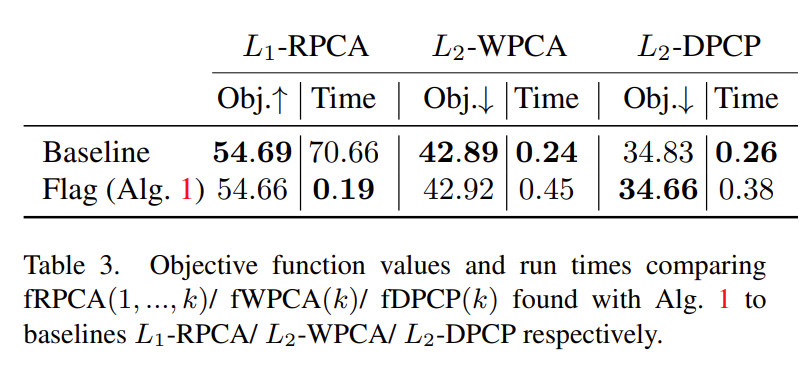

In [1]:
import IPython.display as display

display.display(display.Image(filename="./Results/table3.png",width=800, height=600))